In [3]:
folder_name = '../../data/variant_filtering/depth'

# read files that have '.regions.bed' extension in folder as a list
import os
files = [f for f in os.listdir(folder_name) if f.endswith('.regions.bed')]

# create a pandas dataframe where each column is a file
# and each row is a depth value by reading each file's fourth column
import pandas as pd
df = pd.DataFrame()
for file in files:
    file_path = os.path.join(folder_name, file)
    sample = file.split('.')[0]
    df[sample] = pd.read_csv(file_path, sep='\t', header=None)[3]

# add a column that contains the chromosome, one the start position and one the end position
df['chrom'] = pd.read_csv(file_path, sep='\t', header=None)[0]
df['start'] = pd.read_csv(file_path, sep='\t', header=None)[1]
df['end'] = pd.read_csv(file_path, sep='\t', header=None)[2]

# remove rows that don't have "chr" in the chromosome column
# but not ChrX and ChrY
df = df[df['chrom'].str.contains('Chr')]
df = df[~df['chrom'].str.contains('ChrX')]
df = df[~df['chrom'].str.contains('ChrY')]

In [4]:
# get a new series with the sum of each row of columns meeting
# a condition in their name to group them by population:
# ll_ca = sel (Southern Eurasian Lynx)
# ll_ki or ll_ur = wel (Western Eurasian Lynx)
# ll_ya or ll_vl = eel (Eastern Eurasian Lynx)
# lp_sm = lpa (Iberian Lynx)

populations = {
    'sel': [sample for sample in df.columns if 'll_ca' in sample],
    'wel': [sample for sample in df.columns if 'll_ki' in sample or 'll_ur' in sample],
    'eel': [sample for sample in df.columns if 'll_ya' in sample or 'll_vl' in sample],
    'lpa': [sample for sample in df.columns if 'lp_sm' in sample]
}

populations_df = pd.DataFrame()
for pop, samples in populations.items():
    populations_df[pop] = df.filter(items=samples).sum(axis=1)


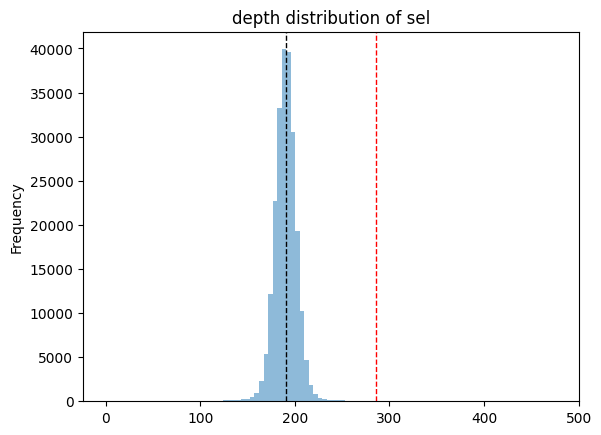

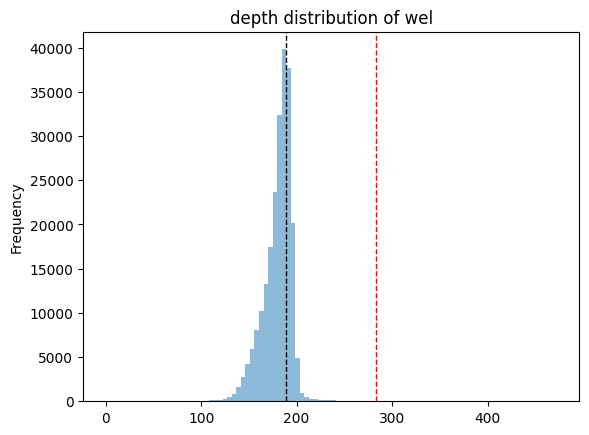

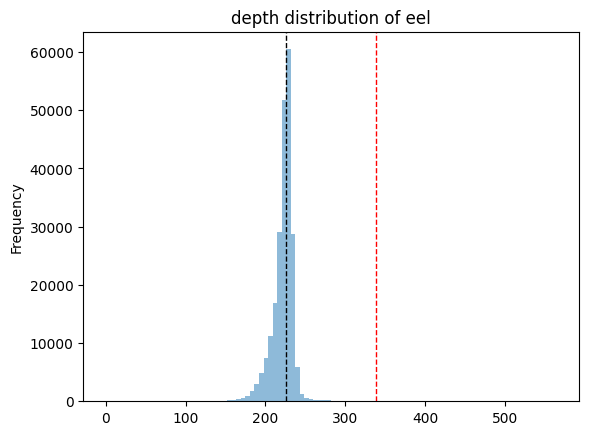

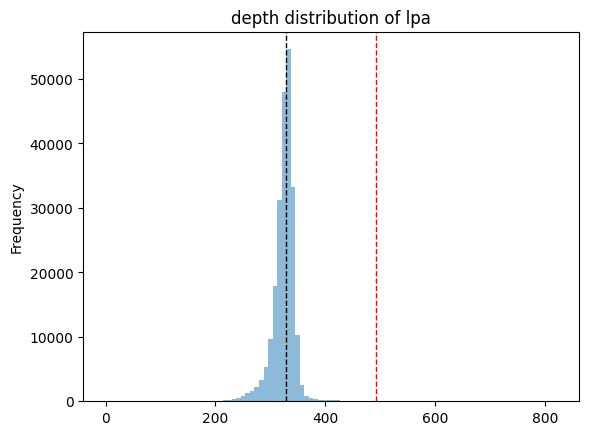

In [5]:
# draw an histogram of each population
# showing only values between and 2 times the mode
# add a vertical line at the mode and one at 1.5 times the mode
import matplotlib.pyplot as plt
for pop in populations_df.columns:
    populations_df[pop].plot.hist(bins=100, alpha=0.5, label=pop, range=(0, 2.5*populations_df[pop].mode().values[0]))
    plt.axvline(populations_df[pop].mode().values[0], color='k', linestyle='dashed', linewidth=1)
    plt.axvline(1.5*populations_df[pop].mode().values[0], color='r', linestyle='dashed', linewidth=1)
    plt.title(f'depth distribution of {pop}')
    plt.show()

In [6]:
# create a new dataframe with one row for each region and one column for each population
# plus the chromosome, start and end columns
# the value of each cell is either pass or fail depending on the condition
# that the depth is between 0 and 1.5 times the mode
regions_df = pd.DataFrame()
regions_df['chrom'] = df['chrom']
regions_df['start'] = df['start']
regions_df['end'] = df['end']

modes = populations_df.mode().iloc[0] * 1.5
for pop in populations_df.columns:
    regions_df[pop] = populations_df[pop].apply(lambda x: 'pass' if x <= modes[pop] else 'fail')

In [7]:
# write the dataframe to a file
regions_df.to_csv('../../data/variant_filtering/depth/regions_depth_filtering.tsv', sep='\t', index=False)
# write a bed file for each population with the regions that did not pass the filter
for pop in populations_df.columns:
    regions_df[regions_df[pop] == 'fail'][['chrom', 'start', 'end']].to_csv(f'../../data/variant_filtering/depth/{pop}.rd_filter.bed', sep='\t', index=False, header=False)


In [8]:
# print the amount of regions that pass and fail in each population
for pop in populations_df.columns:
    print(f'{pop}:')
    print(regions_df[pop].value_counts())
    print()

sel:
sel
pass    227514
fail      1050
Name: count, dtype: int64

wel:
wel
pass    227691
fail       873
Name: count, dtype: int64

eel:
eel
pass    227558
fail      1006
Name: count, dtype: int64

lpa:
lpa
pass    227362
fail      1202
Name: count, dtype: int64



In [9]:
# print the amount of regions that have a value of fail in all populations
print('all fail:')
print((regions_df[populations_df.columns] == 'fail').all(axis=1).value_counts())


all fail:
False    227850
True        714
Name: count, dtype: int64


In [10]:
# print the amount of regions that are fail in 'lpa' and pass in the other populations
print('lpa fail and others pass:')
fail_lpa_pass_others = (regions_df['lpa'] == 'fail') & (regions_df[['sel', 'wel', 'eel']] == 'pass').all(axis=1)
print(fail_lpa_pass_others.value_counts())

lpa fail and others pass:
False    228289
True        275
Name: count, dtype: int64
